Тут я использую нейронку EIDM. Ее описание встречается только тут:

https://link.springer.com/article/10.1007/s11227-023-05197-0

Сейчас она распознает только 4 класса веб атак. В теории она сможет хорошо распозновать 15 класаов.

In [1]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif


from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Embedding
from tensorflow.keras.layers import LSTM, Conv1D,Conv2D, MaxPooling1D, Flatten,Bidirectional

from tensorflow.keras.optimizers import RMSprop, SGD
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler, normalize, LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [3]:
# MODEL_PATH = './models/EIDM_model.keras'
MODEL_PATH = "./models/EIDM_2.keras"

In [4]:
from google.colab import drive
from tqdm import tqdm
import os
drive.mount('/content/drive')
#папка для сохранения чего-то
shared_folder_path = '/content/drive/MyDrive/dudos/'

Mounted at /content/drive


In [40]:
def save_df( path: str, name: str):
  # Убедитесь, что папка существует
  os.makedirs(path, exist_ok=True)

  # Определите путь для сохранения файла
  file_path = os.path.join(path, name)

  # Укажите размер чанка
  chunksize = 10000

  # Откройте файл для записи
  with open(file_path, 'w') as f:
      # Запишите заголовок вручную
      df.iloc[:0].to_csv(f, index=False)

      # Создайте tqdm-объект для отслеживания прогресса
      with tqdm(total=len(df), desc="Saving to CSV", unit="row") as pbar:
          # Итерация по чанкам
          for i in range(0, len(df), chunksize):
              df_chunk = df.iloc[i:i+chunksize]
              df_chunk.to_csv(f, header=False, index=False)
              pbar.update(len(df_chunk))

  # Отображение количества значений в столбце 'Label'
  print(df['Label'].value_counts())

In [41]:

import requests, zipfile, io
from tqdm import tqdm

# Работа с датосетом

In [42]:
#data_path = "./web_attacks_balanced.csv"
data_p = "/dataset/bin_full_aboba_dataset.csv"
# data_p = "/dataset/aboba_dataset.csv"
data_path = shared_folder_path + data_p
#read dataset
data= pd.read_csv(data_path).replace([np.inf, -np.inf], np.nan).dropna(how="any")
# data= pd.read_csv(data_path).replace([np.inf, -np.inf], np.nan)
# data = data.iloc[:, :-7]
data.shape

(550871, 20)

In [43]:
# Вывод первых 5 строк набора данных
print(data.head())

# Вывод информации о наборе данных
print(data.info())

   ip.id  ip.flags.df  ip.ttl  ip.len  ip.dsfield  tcp.srcport  tcp.seq  \
0  46834          0.0   247.0    40.0           0      53026.0      0.0   
1   3793          1.0    56.0   537.0           8        443.0      1.0   
2      0          1.0    59.0    80.0           0      59206.0      1.0   
3   8559          1.0    55.0    54.0           0      52239.0      1.0   
4  54321          0.0   244.0    40.0           8      44034.0      0.0   

   tcp.len  tcp.hdr_len  tcp.flags.fin  tcp.flags.syn  tcp.flags.reset  \
0      0.0         20.0            0.0            1.0              0.0   
1    485.0         32.0            0.0            0.0              0.0   
2      0.0         60.0            0.0            0.0              0.0   
3      2.0         32.0            0.0            0.0              0.0   
4      0.0         20.0            0.0            1.0              0.0   

   tcp.flags.push  tcp.flags.ack  tcp.flags.urg  tcp.flags.cwr  \
0             0.0            0.0      

In [50]:
data["label"].value_counts()

label
0    315729
1    235142
Name: count, dtype: int64

In [45]:
# values = [
#     'masscan', 'zmap', 'hping_syn', 'unicorn_conn', 'nmap_syn', 'unicorn_syn',
#     'nmap_connect', 'bonafide'
# ]
# new_data =data[data.label.isin (values) != False ]

In [46]:
# new_data["label"].value_counts()

Series([], Name: count, dtype: int64)

In [47]:
# матрица коллеряции
# import matplotlib.pyplot as plt
# import seaborn as sns

# # вычисляем матрицу корреляции
# correlationmatrix = data.corr()

# # создаем тепловую карту для визуализации матрицы корреляции
# plt.figure(figsize=(60, 40))
# sns.heatmap(correlationmatrix, annot=True, cmap='coolwarm', linewidths=.5)
# plt.title('Correlation Matrix')
# plt.show()

In [48]:
# filtered_data = data.loc[data['Label'] == 'BENIGN']
# _=filtered_data.pop('Label')

In [51]:
#split dataset to train and test

# labels = data.pop('Label')
labels = data.pop('label')
# Вывод уникальных значений меток
unique_labels = labels.unique()
print("Unique Labels:")
print(unique_labels)
#print(labels)
pdtrain_data, pdtest_data, pdtrain_Label, pdtest_label = train_test_split(data,labels, test_size=0.2,shuffle=True,stratify=labels)

Unique Labels:
[0 1]


In [52]:
len(unique_labels)

2

In [53]:
pdtrain_Label.info()

<class 'pandas.core.series.Series'>
Index: 440696 entries, 172767 to 433313
Series name: label
Non-Null Count   Dtype
--------------   -----
440696 non-null  int64
dtypes: int64(1)
memory usage: 6.7 MB


In [54]:
#convert data from pd to numpy arrary
train_data = pdtrain_data.to_numpy()
test_data = pdtest_data.to_numpy()

# filtered_data=filtered_data.to_numpy()


train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
# filtered_data= filtered_data.astype('float32')


#normalize data
train_data= normalize(train_data, axis=1, norm='l1')
test_data= normalize(test_data, axis=1, norm='l1')
# filtered_data = normalize(filtered_data, axis=1, norm='l1')

In [55]:
train_data[0]

array([8.535e-01, 3.651e-05, 2.264e-03, 1.460e-03, 0.000e+00, 1.419e-01,
       3.651e-05, 0.000e+00, 7.302e-04, 0.000e+00, 0.000e+00, 3.651e-05,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00], dtype=float32)

In [56]:
#reshape data to 3D (потому что в основе и первым слоем идет сверточная нейронная сеть (она работает с фото))
train_data=train_data.reshape(train_data.shape[0],train_data.shape[1])
test_data=test_data.reshape(test_data.shape[0],test_data.shape[1])
# filtered_data = filtered_data.reshape(filtered_data.shape[0], filtered_data.shape[1])

In [57]:

#feature selection
test = SelectKBest(score_func=f_classif, k=19)
fit = test.fit(train_data, pdtrain_Label)
np.set_printoptions(precision=3)
# print(fit.scores_)

train_data = fit.transform(train_data)
# features = fit.transform(train_data)

# Summarize selected features

# train_data = features
print(test_data.shape)
test_data = fit.transform(test_data)

# filtered_data = fit.transform(filtered_data)

(110175, 19)


In [58]:
pdtrain_Label.info()

<class 'pandas.core.series.Series'>
Index: 440696 entries, 172767 to 433313
Series name: label
Non-Null Count   Dtype
--------------   -----
440696 non-null  int64
dtypes: int64(1)
memory usage: 6.7 MB


In [59]:
# подготовка и нормализация данных, что бы на этом можно было обучать нейронную сеть

label_encoder = LabelEncoder()
#convert string labels to int values to be able to classify them
trainVec = label_encoder.fit_transform(pdtrain_Label)
testVec = label_encoder.fit_transform(pdtest_label)


#categorize labels
train_labels = keras.utils.to_categorical(trainVec)
test_labels = keras.utils.to_categorical(testVec)

In [60]:
# reshape data to 3D (потому что в основе и первым слоем идет сверточная нейронная сеть (она работает с фото))
train_data=train_data.reshape(train_data.shape[0],train_data.shape[1],1)
test_data=test_data.reshape(test_data.shape[0],test_data.shape[1],1)
# filtered_data = filtered_data.reshape(filtered_data.shape[0], filtered_data.shape[1],1)
print(train_data.shape)

(440696, 19, 1)


In [61]:
train_data.shape

(440696, 19, 1)

In [62]:
train_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

# Настройка модели

In [65]:
# prepare  Model
model = Sequential()

initializer = keras.initializers.LecunUniform()

# model.add(Dense(19,kernel_initializer=initializer,activation='relu'))
# # model.add(Conv1D(100, 20, activation='relu'))
# model.add(Conv1D(60, 10, activation='relu'))
# model.add(MaxPooling1D())
# model.add(Dropout(0.2))
# # Flatten the results to one dimension for passing into our next layer
# model.add(Flatten())
# model.add(Dense(120,kernel_initializer=initializer,activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(80,kernel_initializer=initializer,activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(40,kernel_initializer=initializer,activation='relu'))
# model.add(Dropout(0.2))
# # model.add(Dense(60,kernel_initializer=initializer,activation='relu'))
# # model.add(Dropout(0.2))
# # model.add(Dense(60,kernel_initializer=initializer,activation='relu'))
# # model.add(Dropout(0.2))
# # model.add(Dense(40,kernel_initializer=initializer,activation='relu'))
# # model.add(Dropout(0.2))


model.add(Dense(19,kernel_initializer=initializer,activation='relu'))
# model.add(Conv1D(100, 20, activation='relu'))
model.add(Conv1D(20, 10, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))
# Flatten the results to one dimension for passing into our next layer
model.add(Flatten())
model.add(Dense(200,kernel_initializer=initializer,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(120,kernel_initializer=initializer,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(80,kernel_initializer=initializer,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(60,kernel_initializer=initializer,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(40,kernel_initializer=initializer,activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(40,kernel_initializer=initializer,activation='relu'))
# model.add(Dropout(0.2))

initializer = keras.initializers.GlorotNormal()

model.add(Dense(2, activation='sigmoid',kernel_initializer=initializer))
# In[33]:


#opt = RMSprop(lr = 0.008, momentum=0.9)
opt = keras.optimizers.Adam(learning_rate=0.00005)
# opt = keras.optimizers.Adam(learning_rate=0.005)
# opt = SGD(lr=0.05,momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



In [66]:

print(train_data.shape)
print(train_labels.shape)

# print(test_data.shape)
# print(test_labels.shape)

history = model.fit(train_data, train_labels,
                    batch_size=10000,
                    epochs=100,
                    validation_data=(test_data, test_labels))



(440696, 19, 1)
(440696, 2)
Epoch 1/100
45/45 [==============================] - 4s 27ms/step - loss: 0.6872 - accuracy: 0.5932 - val_loss: 0.6698 - val_accuracy: 0.7813
Epoch 2/100
45/45 [==============================] - 1s 17ms/step - loss: 0.6572 - accuracy: 0.7386 - val_loss: 0.6102 - val_accuracy: 0.8916
Epoch 3/100
45/45 [==============================] - 1s 16ms/step - loss: 0.5832 - accuracy: 0.8236 - val_loss: 0.4828 - val_accuracy: 0.8885
Epoch 4/100
45/45 [==============================] - 1s 19ms/step - loss: 0.4552 - accuracy: 0.8654 - val_loss: 0.3398 - val_accuracy: 0.8875
Epoch 5/100
45/45 [==============================] - 1s 20ms/step - loss: 0.3580 - accuracy: 0.8794 - val_loss: 0.3054 - val_accuracy: 0.8864
Epoch 6/100
45/45 [==============================] - 1s 15ms/step - loss: 0.3311 - accuracy: 0.8836 - val_loss: 0.3030 - val_accuracy: 0.8863
Epoch 7/100
45/45 [==============================] - 1s 14ms/step - loss: 0.3233 - accuracy: 0.8852 - val_loss: 0.3010 -

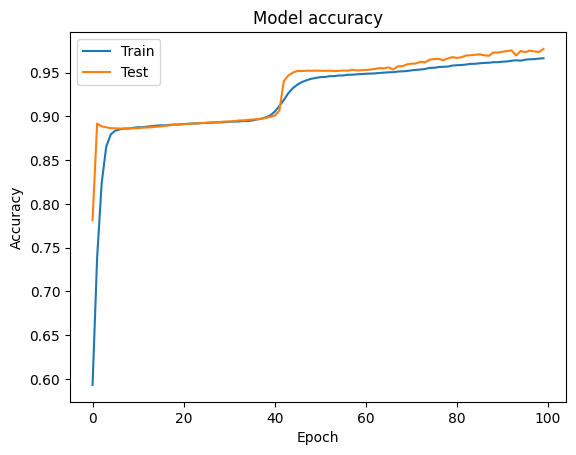

In [69]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Обучение и пр

In [ ]:
model.save('/content/drive/MyDrive/dudos/models/EIDM_2_1_classes.keras')

# Проверка результатов

In [ ]:
test_labels

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
model.save(MODEL_PATH)

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/dudos/models/EIDM_8_3_classes.keras')

In [ ]:
# чем меньше loss и больше accuracy тем лучше
# ниже мы проверяем нейронную сеть

score = model.evaluate(test_data, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


predict = model.predict(test_data,verbose=1)
print(predict)
test_labels


Test loss: 0.023979822173714638
Test accuracy: 0.994545042514801
3443/3443 [==============================] - 7s 2ms/step
[[4.256e-02 9.350e-01]
 [1.000e+00 0.000e+00]
 [1.000e+00 3.429e-24]
 ...
 [3.972e-02 9.386e-01]
 [6.072e-02 9.132e-01]
 [3.354e-02 9.466e-01]]


array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
b = np.zeros_like(predict)
b[np.arange(len(predict)), predict.argmax(1)] = 1

# print('Точность равна =',(test_labels == b).sum()/(len(b)*4))
count = 0
a = b.shape
for i in range(a[0]):
    if (b[i] == test_labels[i]).all()  :
        count+=1
# ! грубая это НЕОФИЦИАЛЬНЫЙ ТЕРМИН.
print('Грубая точность', count/a[0])

Грубая точность 0.9966959641718615


In [ ]:
result = model.predict(filtered_data[:3000])
result

94/94 [==============================] - 2s 4ms/step


array([[1.000e+00, 9.398e-12, 3.248e-06, ..., 2.471e-15, 3.024e-11,
        7.653e-11],
       [1.000e+00, 4.943e-10, 3.323e-10, ..., 1.702e-23, 8.773e-19,
        5.717e-17],
       [1.000e+00, 1.149e-05, 5.530e-06, ..., 2.312e-13, 4.175e-11,
        1.072e-09],
       ...,
       [1.000e+00, 1.262e-09, 6.122e-05, ..., 2.170e-10, 1.148e-07,
        2.124e-07],
       [9.999e-01, 3.148e-09, 7.161e-05, ..., 3.717e-10, 1.596e-07,
        2.438e-07],
       [1.000e+00, 2.193e-13, 4.463e-09, ..., 1.189e-28, 2.218e-22,
        4.480e-18]], dtype=float32)

In [ ]:
len(result)
count = 0
for i in range(len(result[:3000])):
  max_v = np.where(result[i] == np.amax(result[i]))[0][0]
  if max_v != 0:
    count += 1
    print(f"Обнаружена атака формата {unique_labels[max_v]}")
if count == 0:
  print(f"Атак не обноруженно")
  count = 0

Атак не обноруженно


# Новый тык пук


In [ ]:
import numpy as np

# Создание примерного массива данных
data = np.array([
    ['X', 'Y', 'A'],
    ['Y', 'Z', 'B'],
    ['Z', 'X', 'A'],
    ['Y', 'X', 'C']
])

# Определенное значение, которое мы хотим оставить
value = 'A'

# Индекс колонки, в которой нужно проверить значение
column_index = 2

# Булева индексация - отбираем только строки, где значение в указанной колонке равно 'A'
filtered_data = data[data[:, column_index] == value]

print(filtered_data)

[['X' 'Y' 'A']
 ['Z' 'X' 'A']]
